In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import zipfile
import os
import glob
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")


In [ ]:
# --- 2. SETUP AND MOUNT DRIVE ---
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)

# --- Define paths ---
FULL_ZIP_PATH = '/content/drive/MyDrive/AZT1D 2025.zip'
EXTRACTION_DIR = '/content/azt1d_extracted'

# --- 3. DEFINE THE ULTIMATE DATA LOADING FUNCTION ---
def load_and_process_all_data(zip_path, extract_to):
    """
    Finds ALL CSVs, flexibly processes each based on the columns it ACTUALLY contains,
    and merges them into a clean, unified time-series.
    """
    # --- Unzipping Logic ---
    print(f"\nExtracting data...")
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"❌ ZIP file not found at: {zip_path}")
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("✅ Extraction complete.")

    # --- Part A: Find ALL CSV files ---
    search_pattern = os.path.join(extract_to, '**', '*.csv')
    all_files = glob.glob(search_pattern, recursive=True)
    if not all_files:
        raise FileNotFoundError(f"❌ No CSV files found inside {extract_to}.")

    print(f"✅ Found {len(all_files)} total CSV files. Flexibly processing and combining...")

    processed_dfs = []
    # --- Part B: Flexibly process each file ---
    for file in all_files:
        try:
            df_temp = pd.read_csv(file)

            # --- Datetime Processing ---
            if 'EventDateTime' in df_temp.columns:
                df_temp['datetime'] = pd.to_datetime(df_temp['EventDateTime'])
            elif 'Gluc. Date' in df_temp.columns and 'Gluc. Time' in df_temp.columns:
                df_temp['datetime'] = pd.to_datetime(df_temp['Gluc. Date'] + ' ' + df_temp['Gluc. Time'])
            else:
                # If no recognizable date column, skip this file
                print(f"⚠️ Skipping file: {os.path.basename(file)} (No valid timestamp column found)")
                continue

            # --- Glucose Processing (Opportunistic) ---
            df_temp['glucose'] = np.nan # Create a standard glucose column
            if 'glucose' in df_temp.columns:
                 # prioritize existing 'glucose' column if present
                pass
            if 'CGM' in df_temp.columns:
                df_temp['glucose'] = df_temp['glucose'].fillna(df_temp['CGM'])
            if 'Readings (CGM / BGM)' in df_temp.columns:
                df_temp['glucose'] = df_temp['glucose'].fillna(df_temp['Readings (CGM / BGM)'])
            if 'Gluc. Value' in df_temp.columns:
                df_temp['glucose'] = df_temp['glucose'].fillna(df_temp['Gluc. Value'])

            # --- Select only the columns that exist in this file ---
            # These are all the columns we care about for the final model
            final_cols = ['datetime', 'glucose', 'Basal', 'TotalBolusInsulinDelivered', 'CarbSize']
            cols_to_keep = [col for col in final_cols if col in df_temp.columns]

            # Only add the dataframe if it has a timestamp and a glucose value
            if 'datetime' in cols_to_keep and 'glucose' in cols_to_keep:
                processed_dfs.append(df_temp[cols_to_keep])

        except Exception as e:
            print(f"⚠️ Error processing file {os.path.basename(file)}: {e}")

    if not processed_dfs:
        raise ValueError("❌ No data could be processed. Check file contents and column names.")

    # --- Part C: Combine, Resample, and Clean ---
    print(f"✅ Successfully processed {len(processed_dfs)} files. Merging into a single time-series...")
    df_combined = pd.concat(processed_dfs, ignore_index=True)
    df_combined.set_index('datetime', inplace=True)
    df_combined.sort_index(inplace=True)

    # Define aggregation methods
    aggregations = {
        'glucose': 'mean',
        'Basal': 'mean',
        'TotalBolusInsulinDelivered': 'sum',
        'CarbSize': 'sum'
    }

    df_resampled = df_combined.resample('5T').agg(aggregations)

    # Intelligently fill NaNs
    df_resampled['glucose'].interpolate(method='linear', limit_direction='both', inplace=True)
    df_resampled['Basal'].fillna(method='ffill', inplace=True)
    df_resampled[['TotalBolusInsulinDelivered', 'CarbSize']] = df_resampled[['TotalBolusInsulinDelivered', 'CarbSize']].fillna(0)
    df_resampled.dropna(inplace=True) # Final cleanup

    print("✅ Data loading and preprocessing complete!")
    return df_resampled

# --- 4. EXECUTE THE FUNCTION ---
try:
    df_clean = load_and_process_all_data(FULL_ZIP_PATH, EXTRACTION_DIR)

    print("\n" + "="*50)
    print("   SUCCESS! CLEAN DATA IS READY FOR MODELING")
    print("="*50)

    print("\n--- Final Clean Data Sample ---")
    print(df_clean.head())

    print("\n--- Final DataFrame Info ---")
    df_clean.info()

except (FileNotFoundError, KeyError, ValueError, Exception) as e:
    print(f"\nAn error occurred during the process: {e}")

    print("Creating a fallback simulated dataframe...")
    N_SAMPLES = 5000
    df_clean = pd.DataFrame({
        'glucose': 120 + 30 * np.sin(np.arange(N_SAMPLES) * 0.1) + np.random.normal(0, 5, N_SAMPLES),
        'Basal': np.random.rand(N_SAMPLES) * 2,
        'TotalBolusInsulinDelivered': np.zeros(N_SAMPLES),
        'CarbSize': np.zeros(N_SAMPLES)
    })


Mounting Google Drive...
Mounted at /content/drive

Extracting data...
✅ Extraction complete.
✅ Found 30 total CSV files. Flexibly processing and combining...
⚠️ Skipping file: CSV File Subject 65.csv (No valid timestamp column found)
⚠️ Skipping file: CSV File Patient 12.csv (No valid timestamp column found)
✅ Successfully processed 28 files. Merging into a single time-series...
✅ Data loading and preprocessing complete!

   SUCCESS! CLEAN DATA IS READY FOR MODELING

--- Final Clean Data Sample ---
                     glucose  Basal  TotalBolusInsulinDelivered  CarbSize
datetime                                                                 
2023-12-20 00:00:00  135.750  3.603                         0.0       0.0
2023-12-20 00:05:00  136.250  3.603                         0.0       0.0
2023-12-20 00:10:00  136.125  3.603                         0.0       0.0
2023-12-20 00:15:00  136.750  3.603                         0.0       0.0
2023-12-20 00:20:00  137.375  3.603                

In [ ]:
# --- 5. Time-Series Sequencing & Model Building ---

def create_sequences(data, n_lookback, n_horizon):
    X, y = [], []
    for i in range(len(data) - n_lookback - n_horizon + 1):
        feature_window = data[i : i + n_lookback]
        target_value = data[i + n_lookback + n_horizon - 1, 0] # Glucose is the first column
        X.append(feature_window)
        y.append(target_value)
    return np.array(X), np.array(y)

def build_gru_model(input_shape):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        GRU(units=32, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(units=1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [ ]:
# --- 6. Clarke Error Grid Visualization ---

def plot_clarke_error_grid(ref_values, pred_values, title):
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111)
    ax.scatter(ref_values, pred_values, marker='o', color='blue', s=8, alpha=0.3)
    ax.set_xlabel("Reference Glucose (mg/dL)"), ax.set_ylabel("Predicted Glucose (mg/dL)")
    ax.set_title(title), ax.set_xticks(range(0, 401, 50)), ax.set_yticks(range(0, 401, 50))
    ax.set_xlim(0, 400), ax.set_ylim(0, 400), ax.set_aspect('equal'), ax.grid(True)
    # Zone lines and labels
    ax.plot([0, 400], [0, 400], 'k--')
    ax.plot([0, 70], [180, 180], 'k-'), ax.plot([70, 70], [0, 56], 'k-')
    ax.plot([70, 290], [56, 180], 'k-'), ax.plot([180, 180], [70, 400], 'k-')
    ax.plot([180, 400], [70, 300], 'k-'), ax.plot([70, 70], [120, 400], 'k-')
    ax.plot([0, 180], [70, 70], 'k-'), ax.plot([240, 400], [180, 180], 'k-')
    ax.plot([180, 180], [240, 400], 'k-')
    plt.text(30, 15, "A"), plt.text(370, 370, "A"), plt.text(150, 100, "B"), plt.text(100, 150, "B")
    plt.text(30, 220, "C"), plt.text(250, 50, "C"), plt.text(210, 270, "D"), plt.text(30, 370, "E"), plt.text(370, 30, "E")

    # Calculate points in zones
    zones = {'A': 0, 'B': 0}
    for ref, pred in zip(ref_values.flatten(), pred_values.flatten()):
        if (ref < 70 and pred < 70) or (abs(ref - pred) < 0.2 * ref): zones['A'] += 1
        else: zones['B'] += 1
    total_points = len(ref_values)
    zone_a_percent = (zones['A'] / total_points) * 100 if total_points > 0 else 0
    print(f"Clarke Error Grid Analysis: {zone_a_percent:.2f}% of points are in the clinically acceptable Zone A.")
    plt.show()


In [ ]:
# --- 7. Main Model Execution ---

# Define hyperparameters
N_LOOKBACK = 12
N_HORIZON = 6
feature_cols = ['glucose', 'Basal', 'TotalBolusInsulinDelivered', 'CarbSize']
data = df_clean[feature_cols].values
N_FEATURES = data.shape[1]

# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
X, y = create_sequences(data_scaled, N_LOOKBACK, N_HORIZON)

# Chronological train/test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Build and train the model
model = build_gru_model((N_LOOKBACK, N_FEATURES))
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 32)             │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,681 (14.38 KB)

 Trainable params: 3,681 (14.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0142 - mean_absolute_error: 0.0804 - val_loss: 0.0013 - val_mean_absolute_error: 0.0284
Epoch 2/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0019 - mean_absolute_error: 0.0337 - val_loss: 0.0011 - val_mean_absolute_error: 0.0260
Epoch 3/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0016 - mean_absolute_error: 0.0306 - val_loss: 9.7595e-04 - val_mean_absolute_error: 0.0239
Epoch 4/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0286 - val_loss: 9.7034e-04 - val_mean_absolute_error: 0.0237
Epoch 5/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013 - mean_absolute_error: 0.0274 - val_loss: 9.2740e-04 - val_mean_absolute_error: 0.0234
Epoch 6/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0012 - mean_absolute_error: 0.0256 - val_loss: 9.2794e-04 - val_mean_absolute_error: 0.0236
Epoch 7/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0011 - mean_

198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Test Mean Absolute Error (MAE): 11.53 mg/dL
Clinical Accuracy (predictions within ±15.0 mg/dL): 73.84%


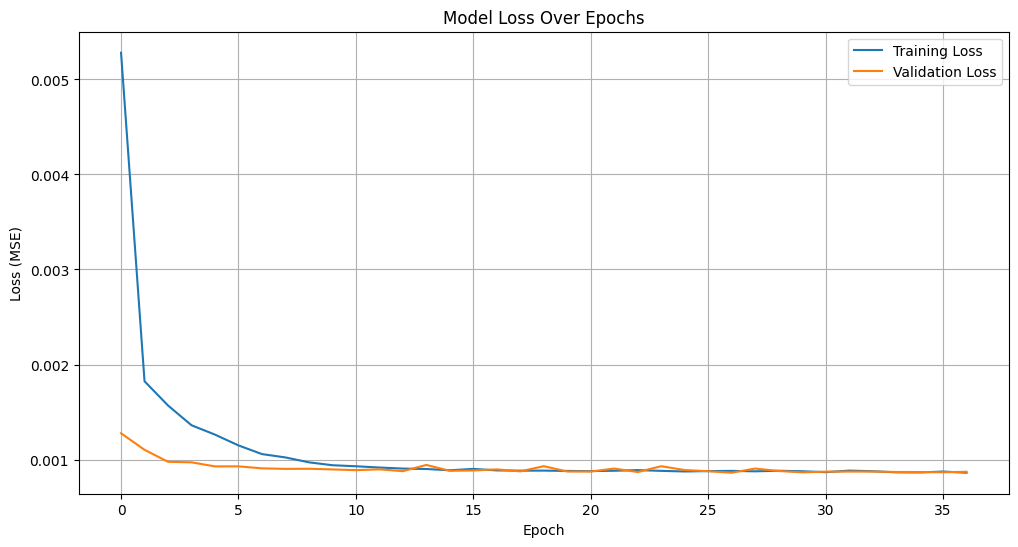

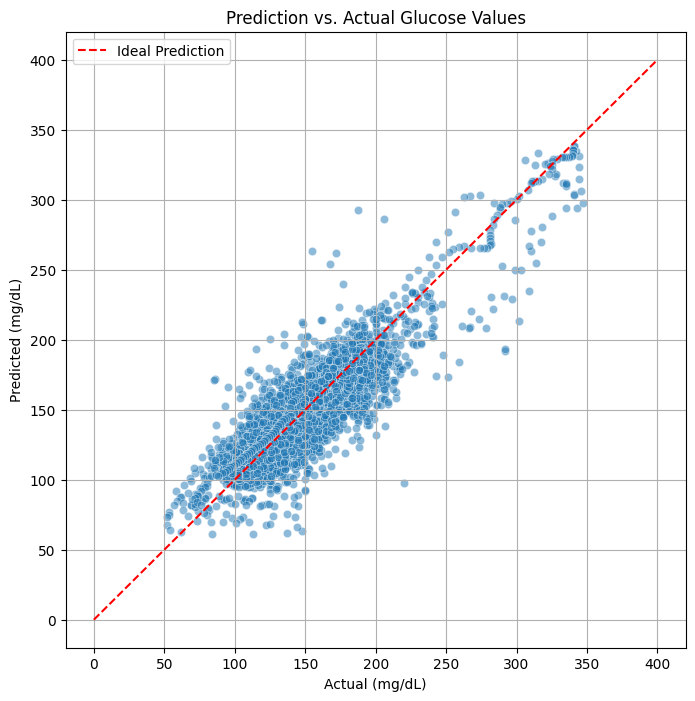

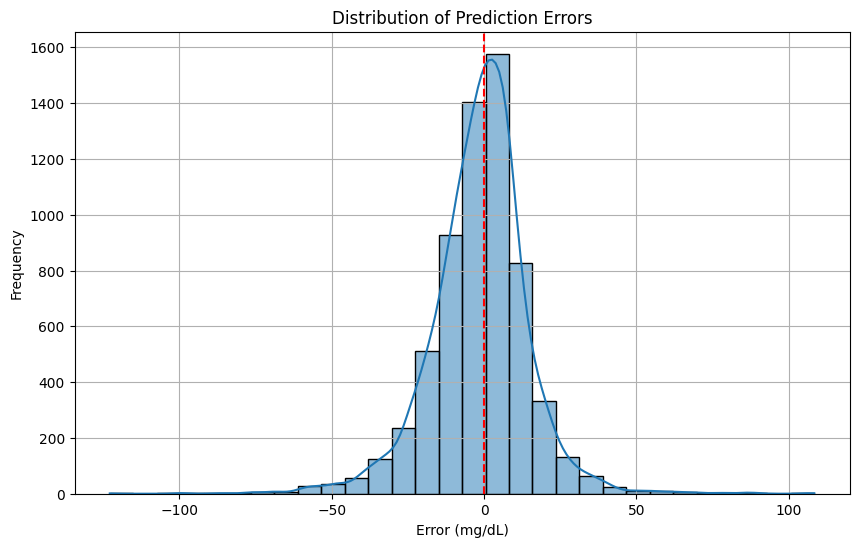

Clarke Error Grid Analysis: 93.00% of points are in the clinically acceptable Zone A.


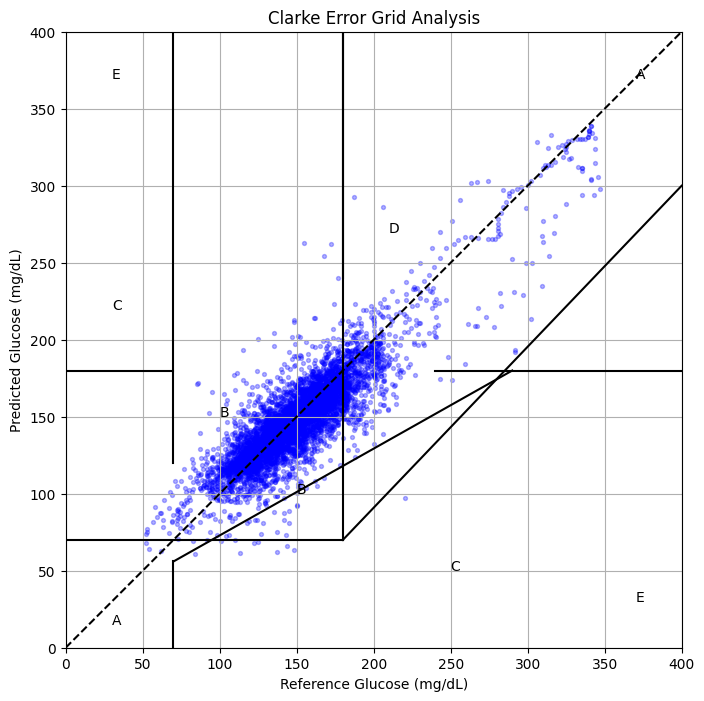

In [ ]:
# --- 8. Enhanced Evaluation & Visualization ---
predictions_scaled = model.predict(X_test).flatten()

dummy_predictions = np.zeros((len(predictions_scaled), N_FEATURES))
dummy_predictions[:, 0] = predictions_scaled
predictions_real = scaler.inverse_transform(dummy_predictions)[:, 0]

dummy_actuals = np.zeros((len(y_test), N_FEATURES))
dummy_actuals[:, 0] = y_test
actuals_real = scaler.inverse_transform(dummy_actuals)[:, 0]

errors = predictions_real - actuals_real
mae_real = np.mean(np.abs(errors))
print(f"\nTest Mean Absolute Error (MAE): {mae_real:.2f} mg/dL")

TOLERANCE = 15.0
accuracy = np.mean(np.abs(errors) <= TOLERANCE) * 100
print(f"Clinical Accuracy (predictions within ±{TOLERANCE} mg/dL): {accuracy:.2f}%")

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss'), plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs'), plt.xlabel('Epoch'), plt.ylabel('Loss (MSE)'), plt.legend(), plt.grid(True), plt.show()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=actuals_real, y=predictions_real, alpha=0.5)
plt.plot([0, 400], [0, 400], 'r--', label='Ideal Prediction')
plt.title('Prediction vs. Actual Glucose Values'), plt.xlabel('Actual (mg/dL)'), plt.ylabel('Predicted (mg/dL)'), plt.legend(), plt.grid(True), plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribution of Prediction Errors'), plt.xlabel('Error (mg/dL)'), plt.ylabel('Frequency'), plt.axvline(0, color='r', linestyle='--'), plt.grid(True), plt.show()

plot_clarke_error_grid(actuals_real, predictions_real, "Clarke Error Grid Analysis")

